<h1><center>Report 11</center></h1>
<h3><center>Jiachen Tian</center><h3>

# Introduction
Glint detection is almost finished. Due to its size, illumination change and unpredictable shape, glint could hardly be put in the same algorithm as the pupil. Therefore, a new algorithm is devised exclusively for glint detection which is demonstrated below. 

# Setup
Setup path to include our files. import them. use `autoreload` to get changes in as they are made. 

In [39]:
import os
import sys
import cv2
from matplotlib import pyplot as plt
import statistics 
import numpy as np

# load our code
sys.path.insert(0, os.path.abspath('../'))
from plotting import auto_draw
# specific to jupyter notebook
from jupyter_help import cvplt, cvplt_sub
#Import image processing function from optimization
# load any changes as we make them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First Filtering
Get the threshold image exclusive for the glint

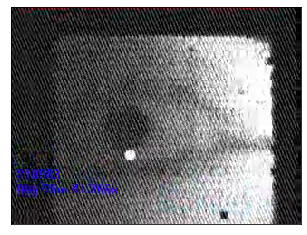

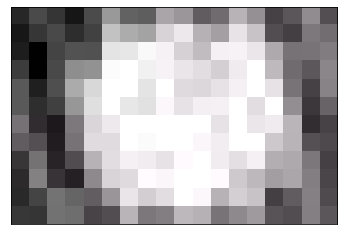

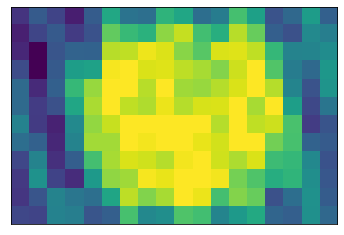

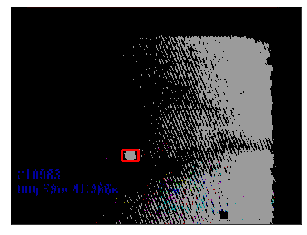

In [30]:
#Read in the original image
image = cv2.imread("../input/chosen_pic.png")
#Keep a copy
origin = image
#Crop the image based on user selected area
sample = image[158:170, 122:140] #User chosen coordinates
start_point = (122, 158)
end_point = (140, 170)
color = (255, 0, 0)
#Run auto threshold on the cropped image
gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
blurred = cv2.blur(gray,(1, 1))
thre,proc_small = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#affect the threshold on the big image
_, proc_big = cv2.threshold(image, thre, thre, cv2.THRESH_BINARY)
keep = proc_big.copy()
new = proc_big.copy()
result_img = proc_big.copy()
#Draw the box on the image
cv2.rectangle(keep,start_point, end_point, color, 2) 

cvplt(image)
cvplt(sample)
cvplt(gray)
cvplt(keep)

# Algorithm creation

In [23]:
#From this point, we gonna trust the user for make the correct rectangle in the first place
#Divide the rectangle
x_start = 158
x_end = 170
y_start = 122
y_end = 140
x_mid = int((x_end+x_start)/2)
y_mid = int((y_end+y_start)/2)

def core(x_start, x_end, y_start, y_end, x_mid, y_mid):
    first = proc_big[x_start:x_mid, y_start:y_mid]#Top left
    second = proc_big[x_mid:x_end, y_start:y_mid]#bottom left
    third = proc_big[x_start:x_mid, y_mid:y_end]#top right
    forth = proc_big[x_mid:x_end, y_mid:y_end]#bottom right
    #Find ratio  
    #Since it's thresholded, only 0 and others
    first = np.array(first)
    second = np.array(second)
    third = np.array(third)
    forth = np.array(forth)

    #Find all the nonzeros
    n_first = np.count_nonzero(first)
    n_second = np.count_nonzero(second)
    n_third = np.count_nonzero(third)
    n_forth = np.count_nonzero(forth)

    #find the ratio
    t_b_ratio = (n_first+n_third)/(n_second+n_forth) #top and botom ratio 
    l_r_ratio = (n_first+n_second)/(n_third+n_forth) #Left and right ratio

    return(t_b_ratio, l_r_ratio)

#Original top bottom and original left right ratio
origin_t_b, origin_l_r = core(x_start, x_end, y_start, y_end, x_mid, y_mid)
print("Top and bot ratio", origin_t_b)
print("Left and right ratio", origin_l_r)
# cvplt(first)
# cvplt(second)
# cvplt(third)
# cvplt(forth)

Top and bot ratio 0.9204545454545454
Left and right ratio 0.7157360406091371


# Algorithm running

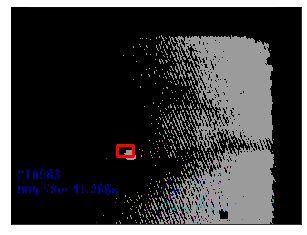

coordinate:  (158, 170, 121, 139, 164, 130)


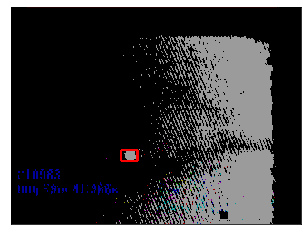

Error 0.24617082321783273


In [38]:
#Now we move the image, see if it can still find the center
x_start = 158 - 5
x_end = 170 - 5
y_start = 122 - 5
y_end = 140 - 5
error = float("inf")
answer = (0, 0)
coor = (0,0,0,0,0,0)
new_start_point = (y_start, x_start)
new_end_point = (y_end, x_end)
x_mid = int((x_end+x_start)/2)
y_mid = int((y_end+y_start)/2)
cv2.rectangle(new, new_start_point, new_end_point, color, 2) 
cvplt(new)

#For now, set the range for 5 because 60f/s means each frame won't move too far away
#Move the rectangle for each rectangle until the minimum error is found
#The original algorithm would move based upon which section contains greatest ratio, but this one, for simpilicity, moves left and down only.
for j in range(0, 5):
    for k in range(0, 5):
        x_start+= 1
        x_end+= 1
        x_mid = int((x_end+x_start)/2)
        y_mid = int((y_end+y_start)/2)
        first_ratio, second_ratio = core(x_start, x_end, y_start, y_end, x_mid, y_mid)
        #Error is bascially just subtraction
        current = abs(first_ratio - origin_t_b) + abs(second_ratio - origin_l_r)
        if current < error:
            error = current
            #Update coordinate
            coor = (x_start, x_end, y_start, y_end, x_mid, y_mid)
            
    y_start+= 1
    y_end+= 1
    #Initialize x
    x_start = 158 - 5
    x_end = 170 - 5
print("coordinate: ", coor)
start_point = (coor[2], coor[0])
end_point = (coor[3], coor[1])
#Now plot this beautiful answer to see if it fits
cvplt(cv2.rectangle(result_img,start_point, end_point, color, 2))
#Print the error
print("Error", error)



# Analysis
As shown above, Even with the best result, the error is around 0.25, which is obviously caused by noise. However, those errors could be filtered in later analysis by fitting the data to normal distribution. 

# Conclusion
Both Pupil tracking and glint tracking is about to finish. The next step would be to further improve precision and find the angle of staring based upon values from both glint and pupil. 